# The model

Context and FLAME GPU resolution process

# Install and Import FLAME GPU

In [24]:
import pyflamegpu
import pyflamegpu.codegen
import sys, random, math
import matplotlib.pyplot as plt
import importlib
#%env CUDA_PATH=/usr/local/cuda

import sugarscape_params
import movement_submodel

importlib.reload(sugarscape_params)
importlib.reload(movement_submodel)

<module 'movement_submodel' from 'D:\\Code\\pyflamegpu-tutorial\\movement_submodel.py'>

# Some constants

Only available in host code!

In [25]:
# Initialisation parameters
ENV_SUGAR_MAX_CAPACITY = 4
ENV_SUGAR_GROWBACK_RATE = 1
MIN_HOTSPOT_DISTANCE = 20
MIN_INIT_AGENT_SUGAR_WEALTH = 5
MAX_INIT_AGENT_SUGAR_WEALTH = 25
MIN_INIT_METABOLISM = 1
MAX_INIT_METABOLISM = 4
PROBABILITY_OF_OCCUPATION = 0.17

SIMULATION_STEPS = 100


# Create a model

In [26]:
def create_model():
    model = pyflamegpu.ModelDescription("sugarscape")
    return model

# Define Environment

In [27]:
def define_environment(model):
    env = model.Environment()
    env.newPropertyInt("sugar_growback_rate", ENV_SUGAR_GROWBACK_RATE)
    env.newPropertyInt("sugar_max_capacity", ENV_SUGAR_MAX_CAPACITY)
    
    # agent status
    env.newPropertyInt("agent_status_unoccupied", sugarscape_params.AGENT_STATUS_UNOCCUPIED)
    env.newPropertyInt("agent_status_occupied", sugarscape_params.AGENT_STATUS_OCCUPIED)
    env.newPropertyInt("agent_status_movement_requested", sugarscape_params.AGENT_STATUS_MOVEMENT_REQUESTED)
    env.newPropertyInt("agent_status_movement_unresolved", sugarscape_params.AGENT_STATUS_MOVEMENT_UNRESOLVED)

# Define Messages

# Define Agents

In [2]:
def define_agents(model):
    agent = model.newAgent("agent")

    # Generic variables
    agent.newVariableInt("x")
    agent.newVariableInt("y")
    agent.newVariableInt("agent_id")
    agent.newVariableInt("status")
    # Sugarscape agent specific variables
    agent.newVariableInt("sugar_level")
    agent.newVariableInt("metabolism")
    # Environment specific variables
    agent.newVariableInt("env_sugar_level")
    agent.newVariableInt("env_max_sugar_level")

    # Metabolise and growback function
    fn = agent.newRTCFunction("metabolise_and_growback", pyflamegpu.codegen.translate(metabolise_and_growback))

    

# Control Flow

In [29]:
def define_execution_order(model, submodel):
    """
      Control flow
    """    
    model.newLayer().addAgentFunction("agent", "metabolise_and_growback")
    model.newLayer().addSubModel(submodel)
    

# Define agent functions

In [30]:
@pyflamegpu.agent_function
def metabolise_and_growback(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):
    sugar_level = pyflamegpu.getVariableInt("sugar_level");
    env_sugar_level = pyflamegpu.getVariableInt("env_sugar_level");
    status = pyflamegpu.getVariableInt("status");
    env_max_sugar_level = pyflamegpu.getVariableInt("env_max_sugar_level");
    # metabolise if occupied
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_occupied")  or 
        status == pyflamegpu.environment.getPropertyInt("agent_status_movement_unresolved")  ):
        # store any sugar present in the cell
        if (env_sugar_level > 0) :
            sugar_level += env_sugar_level
            # Occupied cells are marked as -1 sugar.
            env_sugar_level = -1;

        # metabolise
        sugar_level -= pyflamegpu.getVariableInt("metabolism")

        # check if agent dies
        if (sugar_level == 0) :
            status = pyflamegpu.environment.getPropertyInt("agent_status_unoccupied");
            pyflamegpu.setVariableInt("agent_id", -1);
            env_sugar_level = 0;
            pyflamegpu.setVariableInt("metabolism", 0);

    # growback if unoccupied
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_unoccupied")) :
        env_sugar_level += pyflamegpu.environment.getPropertyInt("sugar_growback_rate")
        if (env_sugar_level > env_max_sugar_level) :
            env_sugar_level = env_max_sugar_level
            
    # set all active agents to unresolved as they may now want to move
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_occupied")) :
        status = pyflamegpu.environment.getPropertyInt("agent_status_movement_unresolved")

    pyflamegpu.setVariableInt("sugar_level", sugar_level);
    pyflamegpu.setVariableInt("env_sugar_level", env_sugar_level);
    pyflamegpu.setVariableInt("status", status);

    return pyflamegpu.ALIVE

# Create Simulation and Population Data

In [31]:
def initialise_population(model):
    # Create some randomised sugar areas for the map
    sugar_hotspots = []
    # Calculate the number of hotspots (average denisty based on that of the original model)
    num_hotspots = int((2 * sugarscape_params.GRID_WIDTH * sugarscape_params.GRID_HEIGHT) / (49*49))
    for i in range(num_hotspots):
        attempts = 0
        while True:
            hs = [random.randint(0, sugarscape_params.GRID_WIDTH - 1), random.randint(0, sugarscape_params.GRID_HEIGHT - 1)]
            # Check if the new hotspot is at least 10 units away from existing ones
            if all(math.sqrt((hx - hs[0]) ** 2 + (hy - hs[1]) ** 2) >= MIN_HOTSPOT_DISTANCE for hx, hy in sugar_hotspots):
                sugar_hotspots.append(hs)
                break  # Valid position found, move to the next hotspot
            # limit attemtps to create a position
            attempts += 1
            if attempts == 100:
                print(f"Warning: Maximum attempts reached creating unique location for sugar hotspot {i}.")
                break

    # Initialize agent population
    init_pop = pyflamegpu.AgentVector(model.Agent("agent"), sugarscape_params.GRID_WIDTH * sugarscape_params.GRID_HEIGHT)
    # Create some random distributions
    normal = random.uniform 
    agent_sugar_dist = lambda: random.randint(MIN_INIT_AGENT_SUGAR_WEALTH, MAX_INIT_AGENT_SUGAR_WEALTH)
    agent_metabolism_dist = lambda: random.randint(MIN_INIT_METABOLISM, MAX_INIT_METABOLISM)
    # loop to create agents / cells
    i = 0
    for x in range(sugarscape_params.GRID_WIDTH):
        for y in range(sugarscape_params.GRID_HEIGHT):
            instance = init_pop[i]
            i += 1
            instance.setVariableInt("x", x)
            instance.setVariableInt("y", y)
            # 10% chance of cell holding an agent
            if normal(0, 1) < PROBABILITY_OF_OCCUPATION:
                instance.setVariableInt("agent_id", i)
                instance.setVariableInt("status", sugarscape_params.AGENT_STATUS_OCCUPIED)
                instance.setVariableInt("sugar_level", agent_sugar_dist())
                instance.setVariableInt("metabolism", agent_metabolism_dist())
            else:
                instance.setVariableInt("agent_id", -1)
                instance.setVariableInt("status", sugarscape_params.AGENT_STATUS_UNOCCUPIED)
                instance.setVariableInt("sugar_level", 0)
                instance.setVariableInt("metabolism", 0)
    
            # Environment-specific variable
            env_sugar_lvl = 0
            hotspot_core_size = 5
    
            for hs in sugar_hotspots:
                hs_x, hs_y = hs  # Unpack hotspot coordinates
                # Compute Euclidean distance to hotspot
                hs_dist = math.sqrt((hs_x - x) ** 2 + (hs_y - y) ** 2)
                # Compute environmental sugar level
                env_sugar_lvl += max(0, 4 - min(4, math.floor(hs_dist / hotspot_core_size)))
            env_sugar_lvl = min(env_sugar_lvl, ENV_SUGAR_MAX_CAPACITY)
    
            # Set environmental sugar variables
            instance.setVariableInt("env_sugar_level", env_sugar_lvl)
            instance.setVariableInt("env_max_sugar_level", env_sugar_lvl) # All cells begin at their local max sugar
    
    return init_pop

In [32]:
def initialise_simulation():
    model = create_model()

    define_environment(model)
    define_agents(model)
    submodel = movement_submodel.add_movement_submodel(model)
    define_execution_order(model, submodel)

    # initialise a randomised population
    init_pop = initialise_population(model)

    # Create the CUDA simulation
    cuda_simulation = pyflamegpu.CUDASimulation(model)
    cuda_simulation.setPopulationData(init_pop);
    
    return cuda_simulation


In [33]:
# delete previous data
!rm -rf data
!mkdir data

cuda_simulation = initialise_simulation() 
cuda_simulation.exportData(f"data/0.json")
# simulate for number of steps and log the complete state
for i in range(SIMULATION_STEPS):
    cuda_simulation.step()
    cuda_simulation.exportData(f"data/{i+1}.json")
print("Simulation complete")    

Simulation complete


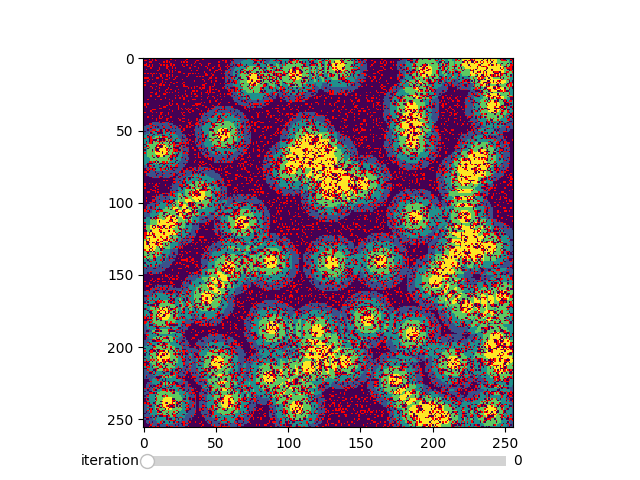

In [34]:
import sugarscape_visualiser
import importlib
importlib.reload(sugarscape_visualiser)
#%matplotlib inline 
%matplotlib widget 
# requires ipympl

#sugarscape_visualiser.plot_state(0)
#sugarscape_visualiser.plot_state(1)
#sugarscape_visualiser.plot_state(20)
#sugarscape_visualiser.plot_state(30)
#sugarscape_visualiser.plot_state(40)

#ani = sugarscape_visualiser.animate_states(10)

sugarscape_visualiser.display_states(100)